In [27]:
# =======================
# IMPORTS
# =======================
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, GlobalAveragePooling2D, LeakyReLU, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.applications import MobileNetV2, EfficientNetB0, ResNet50, VGG16
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_recall_curve, auc
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import random

In [28]:

# =======================
# CONFIGURATIONS
# =======================
IMG_SIZE = 224
BATCH_SIZE = 16
EPOCHS = 15
TFLITE_PATH = "model.tflite"
SEED = 42
LOSS_FUNCTION = 'focal'  # 'binary_crossentropy' or 'focal'
ARCHITECTURE = 'MobileNetV2'     # 'MobileNetV2', 'EfficientNetB0', 'ResNet50', 'VGG16', 'CNN'
ACTIVATION = 'leaky_relu' # 'relu', 'leaky_relu', 'elu'
OPTIMIZER = 'adam'    # 'adam', 'sgd', 'rmsprop'
THRESHOLD = 0.4  # Custom threshold for evaluation

# Set seeds
tf.random.set_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

# Paths
train_path = r"C:\Users\Adars\Desktop\dataset\train"
test_path = r"C:\Users\Adars\Desktop\dataset\test"

In [29]:
# =======================
# NON-SKIN IMAGE DETECTION
# =======================
def is_skin_image(image_path, model, threshold=0.5):
    img = load_img(image_path, target_size=(IMG_SIZE, IMG_SIZE))
    img_array = img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    pred = model.predict(img_array)[0][0]
    return pred > threshold

def load_non_skin_model():
    base_model = MobileNetV2(include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3), weights='imagenet')
    base_model.trainable = False
    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(1, activation='sigmoid')
    ])
    model.load_weights('non_skin_classifier.h5')  # Must be trained separately
    return model

In [30]:
# =======================
# FUNCTIONS
# =======================
def focal_loss(gamma=2.0, alpha=0.25):
    def focal_loss_fn(y_true, y_pred):
        epsilon = K.epsilon()
        y_pred = K.clip(y_pred, epsilon, 1.0 - epsilon)
        p_t = tf.where(K.equal(y_true, 1), y_pred, 1 - y_pred)
        alpha_factor = K.ones_like(y_true) * alpha
        alpha_factor = tf.where(K.equal(y_true, 1), alpha_factor, 1 - alpha_factor)
        cross_entropy = -K.log(p_t)
        loss = alpha_factor * K.pow(1 - p_t, gamma) * cross_entropy
        return K.mean(K.sum(loss, axis=-1))
    return focal_loss_fn

def get_activation_function(name):
    if name == 'relu': return tf.keras.layers.ReLU()
    elif name == 'leaky_relu': return LeakyReLU(alpha=0.3)
    elif name == 'elu': return tf.keras.layers.ELU()
    else: return tf.keras.layers.ReLU()

def get_optimizer(name):
    if name == 'adam': return tf.keras.optimizers.Adam(learning_rate=1e-4)
    elif name == 'sgd': return tf.keras.optimizers.SGD(learning_rate=1e-4, momentum=0.9)
    elif name == 'rmsprop': return tf.keras.optimizers.RMSprop(learning_rate=1e-4)
    else: return tf.keras.optimizers.Adam(learning_rate=1e-4)

def build_model(architecture, activation_fn):
    if architecture == 'MobileNetV2':
        base_model = MobileNetV2(input_shape=(IMG_SIZE, IMG_SIZE, 3), include_top=False, weights='imagenet')
    elif architecture == 'EfficientNetB0':
        base_model = EfficientNetB0(input_shape=(IMG_SIZE, IMG_SIZE, 3), include_top=False, weights='imagenet')
    elif architecture == 'ResNet50':
        base_model = ResNet50(input_shape=(IMG_SIZE, IMG_SIZE, 3), include_top=False, weights='imagenet')
    elif architecture == 'VGG16':
        base_model = VGG16(input_shape=(IMG_SIZE, IMG_SIZE, 3), include_top=False, weights='imagenet')
    elif architecture == 'CNN':
        model = Sequential([
            Conv2D(32, (3,3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
            MaxPooling2D(2,2),
            Conv2D(64, (3,3), activation='relu'),
            MaxPooling2D(2,2),
            Conv2D(128, (3,3), activation='relu'),
            MaxPooling2D(2,2),
            Flatten(),
            Dense(256),
            activation_fn,
            Dropout(0.5),
            Dense(1, activation='sigmoid')
        ])
        return model
    else:
        raise ValueError(f"Invalid architecture: {architecture}")

    base_model.trainable = False
    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(128),
        activation_fn,
        BatchNormalization(),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    return model

def create_data_generators():
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=20,
        zoom_range=0.2,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=True,
        validation_split=0.2
    )

    test_datagen = ImageDataGenerator(rescale=1./255)

    train_gen = train_datagen.flow_from_directory(
        train_path,
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE,
        class_mode='binary',
        subset='training',
        seed=SEED
    )

    val_gen = train_datagen.flow_from_directory(
        train_path,
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE,
        class_mode='binary',
        subset='validation',
        seed=SEED
    )

    test_gen = test_datagen.flow_from_directory(
        test_path,
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE,
        class_mode='binary',
        shuffle=False
    )

    return train_gen, val_gen, test_gen

In [31]:
# =======================
# TRAINING & EVALUATION
# =======================
if __name__ == "__main__":
    train_gen, val_gen, test_gen = create_data_generators()

    model = build_model(ARCHITECTURE, get_activation_function(ACTIVATION))

    loss = focal_loss() if LOSS_FUNCTION == 'focal' else 'binary_crossentropy'
    custom_objects = {'focal_loss_fn': focal_loss(), 'LeakyReLU': LeakyReLU}

    labels = train_gen.classes
    class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(labels), y=labels)
    class_weight_dict = dict(enumerate(class_weights))

    model.compile(
        optimizer=get_optimizer(OPTIMIZER),
        loss=loss,
        metrics=['accuracy', tf.keras.metrics.Recall(name='recall'), tf.keras.metrics.Precision(name='precision')]
    )

    callbacks = [
        EarlyStopping(monitor='val_recall', patience=5, mode='max', restore_best_weights=True),
        ModelCheckpoint('best_model.keras', save_best_only=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)
    ]

Found 7368 images belonging to 2 classes.
Found 1842 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


c:\Users\Adars\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


c:\Users\Adars\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
461/461 ━━━━━━━━━━━━━━━━━━━━ 204s 435ms/step - accuracy: 0.7349 - loss: 0.1296 - precision: 0.7565 - recall: 0.6849 - val_accuracy: 0.8415 - val_loss: 0.0526 - val_precision: 0.9525 - val_recall: 0.7188 - learning_rate: 1.0000e-04
Epoch 2/15
461/461 ━━━━━━━━━━━━━━━━━━━━ 106s 230ms/step - accuracy: 0.8010 - loss: 0.0905 - precision: 0.8506 - recall: 0.7245 - val_accuracy: 0.8599 - val_loss: 0.0425 - val_precision: 0.9585 - val_recall: 0.7524 - learning_rate: 1.0000e-04
Epoch 3/15
461/461 ━━━━━━━━━━━━━━━━━━━━ 104s 226ms/step - accuracy: 0.8065 - loss: 0.0787 - precision: 0.8661 - recall: 0.7195 - val_accuracy: 0.8485 - val_loss: 0.0390 - val_precision: 0.9599 - val_recall: 0.7275 - learning_rate: 1.0000e-04
Epoch 4/15
461/461 ━━━━━━━━━━━━━━━━━━━━ 105s 227ms/step - accuracy: 0.8135 - loss: 0.0682 - precision: 0.8845 - recall: 0.7172 - val_accuracy: 0.8664 - val_loss: 0.0362 - val_precision: 0.9494 - val_recall: 0.7742 - learning_rate: 1.0000e-04
Epoch 5/15
461/461 ━━━━━━━━━━━━━

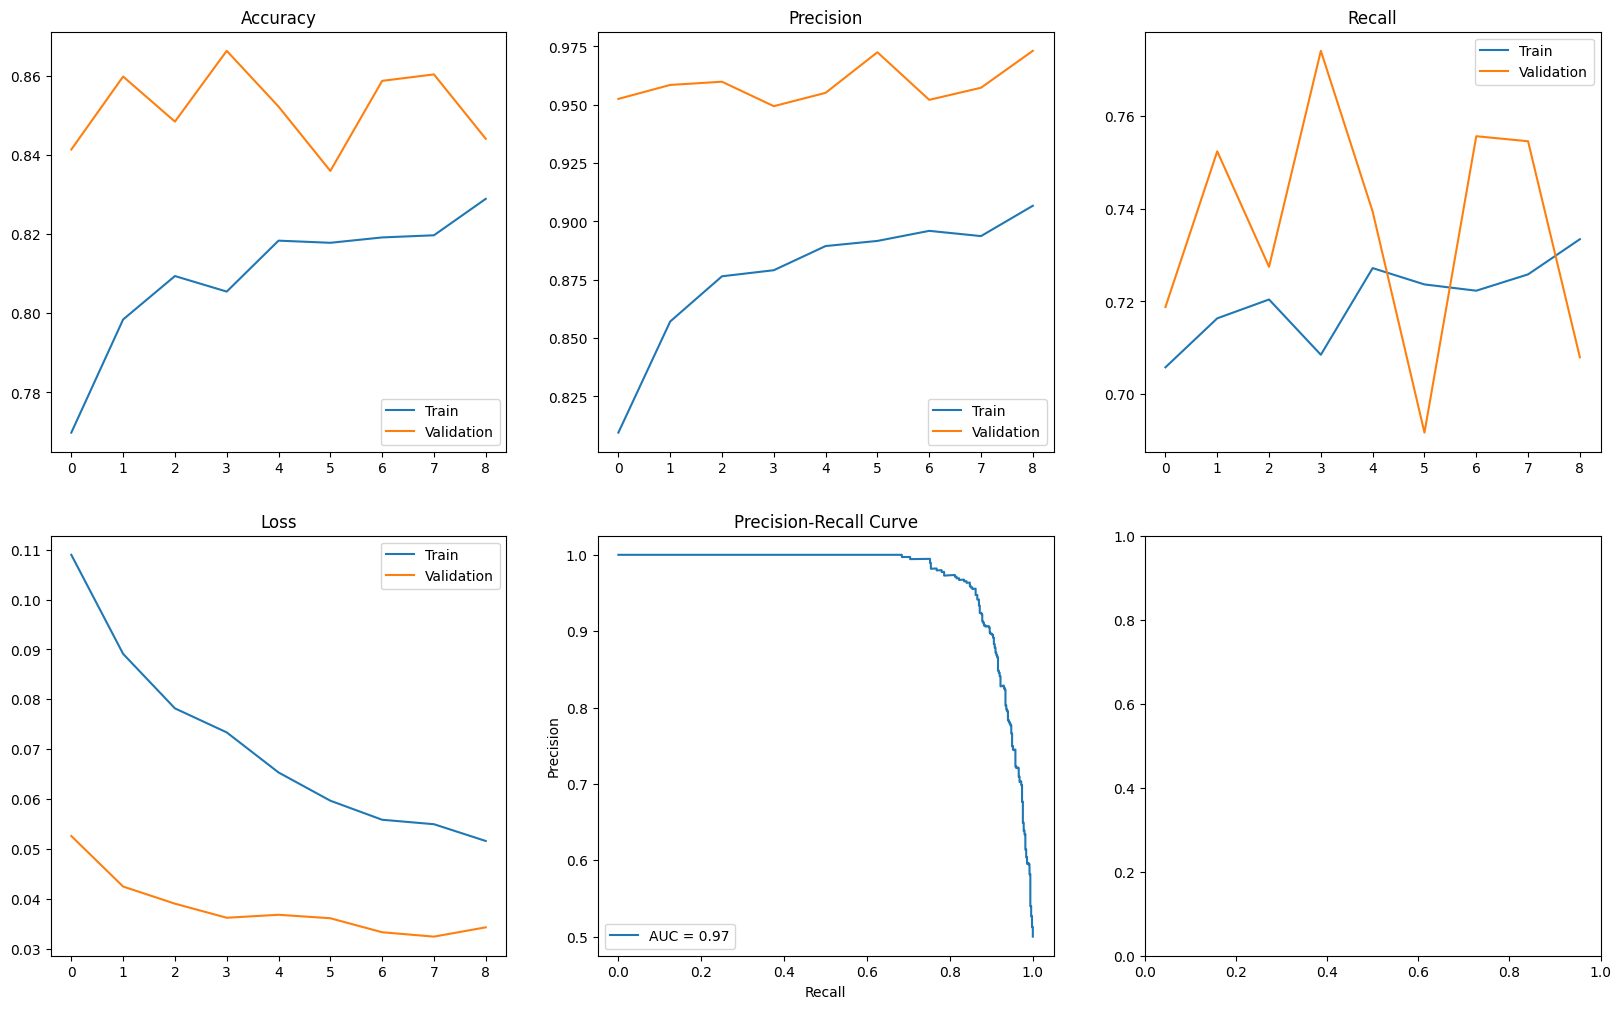

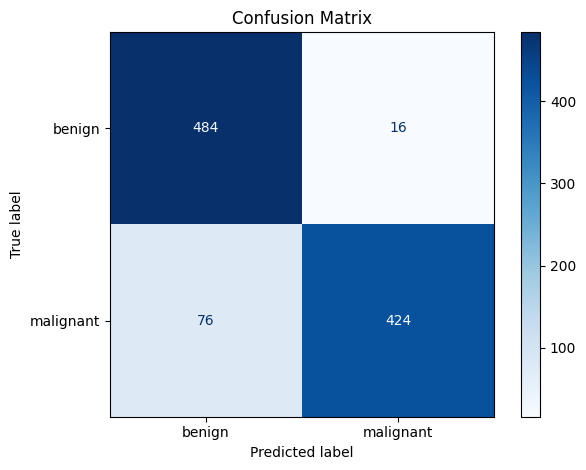

INFO:tensorflow:Assets written to: C:\Users\Adars\AppData\Local\Temp\tmph_zaqvh1\assets


INFO:tensorflow:Assets written to: C:\Users\Adars\AppData\Local\Temp\tmph_zaqvh1\assets


Saved artifact at 'C:\Users\Adars\AppData\Local\Temp\tmph_zaqvh1'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_layer_3')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  2298355397936: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2298355308448: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2298355313200: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2298355311088: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2298355311968: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2298355316544: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2298355312496: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2298355313376: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2298355317952: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2298355990768: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2298

In [32]:
history = model.fit(
        train_gen,
        epochs=EPOCHS,
        validation_data=val_gen,
        callbacks=callbacks,
        class_weight=class_weight_dict
)
model = load_model('best_model.keras', custom_objects=custom_objects)
test_results = model.evaluate(test_gen)
# Visualization and Evaluation
plt.figure(figsize=(20, 12))
plt.subplot(2, 3, 1); plt.plot(history.history['accuracy'], label='Train'); plt.plot(history.history['val_accuracy'], label='Validation'); plt.title('Accuracy'); plt.legend()
plt.subplot(2, 3, 2); plt.plot(history.history['precision'], label='Train'); plt.plot(history.history['val_precision'], label='Validation'); plt.title('Precision'); plt.legend()
plt.subplot(2, 3, 3); plt.plot(history.history['recall'], label='Train'); plt.plot(history.history['val_recall'], label='Validation'); plt.title('Recall'); plt.legend()
plt.subplot(2, 3, 4); plt.plot(history.history['loss'], label='Train'); plt.plot(history.history['val_loss'], label='Validation'); plt.title('Loss'); plt.legend()
plt.subplot(2, 3, 5)
y_probs = model.predict(test_gen)
precision, recall, _ = precision_recall_curve(test_gen.classes, y_probs)
plt.plot(recall, precision, label=f'AUC = {auc(recall, precision):.2f}')
plt.xlabel('Recall'); plt.ylabel('Precision'); plt.title('Precision-Recall Curve'); plt.legend()
plt.subplot(2, 3, 6)
y_pred = (y_probs > THRESHOLD).astype(int)
cm = confusion_matrix(test_gen.classes, y_pred)
ConfusionMatrixDisplay(cm, display_labels=test_gen.class_indices.keys()).plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.tight_layout(); plt.show()
# TFLite Conversion
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_types = [tf.float16]
converter.target_spec.supported_ops = [
    tf.lite.OpsSet.TFLITE_BUILTINS,
    tf.lite.OpsSet.SELECT_TF_OPS
]
tflite_model = converter.convert()
with open(TFLITE_PATH, 'wb') as f:
    f.write(tflite_model)
print(f"\n✅ TFLite model saved to: {TFLITE_PATH}")